In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from IPython.display import display, HTML

# Sembunyikan semua input code
display(HTML("<style>.input {display:none;}</style>"))


# Import CSV files from the same folder
df = pd.read_csv("MasterData.csv")

# Make sure do not use scientific notation
pd.options.display.float_format = '{:.2f}'.format

# Insights for Reseller

In [41]:
top_products = df.groupby("nama_produk")["jumlah_pembelian"].sum().sort_values(ascending=False)
top_products_df = top_products.reset_index()
top_products_df.columns = ["Produk", "Total Pembelian"]
top_products_df.index = range(1, len(top_products_df) + 1)
print("Daftar Produk berdasarkan urutan total pembelian")
top_products_df



Daftar Produk berdasarkan urutan total pembelian


,Produk,Total Pembelian
1,Botol PET Bening 500ml,213
2,Standing Pouch Aluminium 250g,164
3,Botol Kaca Amber 250ml,133
4,Dus Produk Glossy 10x10x10,99
5,Tutup Botol Ulir 28mm,92
6,Stiker Label Vinyl Tahan Air,91
7,Tray Makanan Mika 4 Sekat,80
8,Karton Box Die Cut 20x15x8,66


In [42]:
basket = df.groupby(['bulan_transaksi', 'customer_id', 'nama_produk'])['nama_produk'] \
           .count().unstack().reset_index().fillna(0).set_index(['bulan_transaksi', 'customer_id'])

# Convert quantities to 1/0 (presence of product)
basket = basket > 0 

# Apply Apriori Algorithm
frequent_itemsets = apriori(basket, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

# Filter by lift > 1.2 (stronger relationships)
rules = rules[rules['lift'] > 1.2]

top_rules = rules.head(5)
print("Top 5 Rekomendasi Promo Buy 1 Get 1 berdasarkan data!\n")
for idx, row in top_rules.iterrows():
    antecedent = ', '.join(list(row['antecedents']))
    consequent = ', '.join(list(row['consequents']))
    print(f"{antecedent} & {consequent}")

Top 5 Rekomendasi Promo Buy 1 Get 1 berdasarkan data!

Botol PET Bening 500ml & Tray Makanan Mika 4 Sekat
Tray Makanan Mika 4 Sekat & Botol PET Bening 500ml
Stiker Label Vinyl Tahan Air & Dus Produk Glossy 10x10x10
Dus Produk Glossy 10x10x10 & Stiker Label Vinyl Tahan Air
Standing Pouch Aluminium 250g & Karton Box Die Cut 20x15x8


In [43]:
df['tanggal'] = pd.to_datetime(df['tanggal'])
# 1. Set reference date for Recency calculation
reference_date = df['tanggal'].max() + pd.Timedelta(days=1)

# 2. Build RFM table
rfm = df.groupby('nama_pelanggan').agg({
    'tanggal': lambda x: (reference_date - x.max()).days,  # Recency = days since last purchase
    'order_id': 'nunique',                                # Frequency = unique transactions
    'margin': 'sum'                                       # Monetary = total margin (profit)
}).reset_index()

# Rename columns
rfm.columns = ['nama_pelanggan', 'Recency', 'Frequency', 'Monetary']

# 3. Create RFM Scores (1–5 scale, higher = better)
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1]).astype(int)
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5]).astype(int)
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5]).astype(int)

# 4. Combine scores into RFM Segment
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)

# 5. Calculate RFM Score (sum of scores)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].sum(axis=1)

# 6. Example segmentation based on RFM Score
def segment_customer(score):
    if score >= 12:
        return 'Champions'
    elif score >= 9:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)

# --- Show results ---
# 1. Keep only the relevant columns
df_simple = rfm[['nama_pelanggan', 'Segment']]

# 2. Rename the columns
df_simple = df_simple.rename(columns={
    'nama_pelanggan': 'Customer Name',
    'Segment': 'Customer Segment'
})

# 3. Define custom order
custom_order = ['Champions', 'Loyal Customers', 'Potential Loyalist', 'At Risk']

# 4. Convert 'Customer Segment' to categorical with the custom order
df_simple['Customer Segment'] = pd.Categorical(df_simple['Customer Segment'],
                                               categories=custom_order,
                                               ordered=True)

# 5. Sort by the categorical order
df_simple = df_simple.sort_values(by='Customer Segment').reset_index(drop=True)

# Show result
print("Our Top Customers")
df_simple


Our Top Customers


,Customer Name,Customer Segment
0,Brand Skincare Cantika,Champions
1,Pabrik Keripik Renyah,Champions
2,UMKM Dapur Bunda,Champions
3,CV Minuman Segar,Loyal Customers
4,Kopi Kita Bersama,Loyal Customers
5,PT Makanan Sehat,Loyal Customers
6,PT Roti Enak,Loyal Customers
7,Sambal Nona Roa,Loyal Customers
8,PT Herbal Alami,Potential Loyalist
9,CV Snack Gurih,At Risk


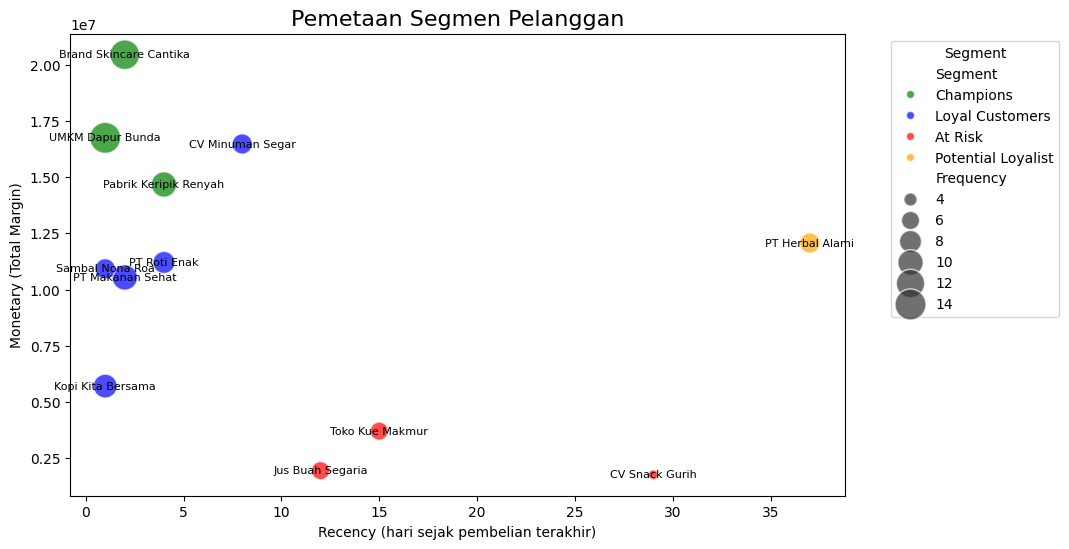

In [44]:
# Scatter plot: Recency vs Monetary, size = Frequency, color = Segment
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm,
    x="Recency", 
    y="Monetary", 
    size="Frequency", 
    hue="Segment",
    palette={
        "Champions":"green", 
        "Loyal Customers":"blue", 
        "Potential Loyalist":"orange", 
        "At Risk":"red"
    },
    sizes=(50, 500),
    alpha=0.7
)

for i, row in rfm.iterrows():
    plt.text(
        row["Recency"], 
        row["Monetary"], 
        str(row["nama_pelanggan"]),   # ganti 'CustomerID' dengan kolom nama customer kamu
        fontsize=8, 
        ha='center', 
        va='center'
    )

plt.title("Pemetaan Segmen Pelanggan", fontsize=16)
plt.xlabel("Recency (hari sejak pembelian terakhir)")
plt.ylabel("Monetary (Total Margin)")
plt.legend(title="Segment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [45]:
# 1. Extract week number from 'tanggal'
df['minggu'] = df['tanggal'].dt.isocalendar().week

# 2. Group by product and week, summing jumlah_pembelian
grouped = df.groupby(['nama_produk', 'minggu'])['jumlah_pembelian'].sum().reset_index()

# # 3. Pivot so rows = product, columns = week
# pivot_table = grouped.pivot(index='nama_produk', columns='minggu', values='jumlah_pembelian').fillna(0)

# # 4. (Optional) Make column names cleaner
# pivot_table.columns = [f"Minggu_{col}" for col in pivot_table.columns]

# pivot_table

# Moving Average settings
ma_period = 3
lead_time = 1  # assume 1 week lead time

results = []

# Loop through each product
for product, df_prod in grouped.groupby("nama_produk"):
    # Sort by minggu
    df_prod = df_prod.sort_values("minggu")

    # Moving Average Forecast
    forecast = df_prod["jumlah_pembelian"].tail(ma_period).mean()

    # Safety Stock = std deviation of last N periods
    safety_stock = df_prod["jumlah_pembelian"].tail(ma_period).std()

    # Reorder Point (ROP) = forecast * lead_time + safety_stock
    rop = forecast * lead_time + safety_stock

    results.append({
        "Produk": product,
        "Prediksi Kebutuhan Minggu Depan": round(forecast),
        "Rekomendasi Stock Tambahan": round(safety_stock),
        "Reorder Point": round(rop)
    })

# Create summary table
summary_df = pd.DataFrame(results)
print("Prediksi dan Rekomendasi Jumlah Stock")
print("Rekomendasi Stock Tambahan: Jumlah stock tambahan yang direkomendasikan untuk mengantisipasi kebutuhan tambahan")
print("Reorder Point: Ketika sudah mencapai jumlah ini, disarankan untuk segera melakukan restock")
summary_df


Prediksi dan Rekomendasi Jumlah Stock
Rekomendasi Stock Tambahan: Jumlah stock tambahan yang direkomendasikan untuk mengantisipasi kebutuhan tambahan
Reorder Point: Ketika sudah mencapai jumlah ini, disarankan untuk segera melakukan restock


,Produk,Prediksi Kebutuhan Minggu Depan,Rekomendasi Stock Tambahan,Reorder Point
0,Botol Kaca Amber 250ml,29,25,54
1,Botol PET Bening 500ml,21,15,36
2,Dus Produk Glossy 10x10x10,21,12,33
3,Karton Box Die Cut 20x15x8,16,5,20
4,Standing Pouch Aluminium 250g,27,22,49
5,Stiker Label Vinyl Tahan Air,18,8,25
6,Tray Makanan Mika 4 Sekat,19,17,36
7,Tutup Botol Ulir 28mm,19,10,29
